# Reducción de dimensionalidad para machine learning en Python

In [44]:
import pandas as pd
import plotnine as pn
from mizani.formatters import percent_format
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from pca import pca
from matplotlib import pyplot as plt

data_location = 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500

In [45]:
tweet_data = pd.read_csv(data_location)

In [46]:
tweet_data.shape

(24000, 56)

In [47]:
tweet_data.head(2)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1427942690738556931,1427772226347098119,1.629283e+12,2021-08-18 12:37:22,200,NaN,@swmrna @MohammedAlDeaye 🙏❤️,und,[],[],322606204,322606204,abdulrahman,عبدالرحمن بن مساعد بن عبدالعزيز🇸🇦,3,12,https://twitter.com/abdulrahman/status/1427942...,[],[],0,NaN,False,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'swmrna', 'name': 'سعدون الشي...",NaN,NaN,NaN,NaN,322606204,عبدالرحمن بن مساعد بن عبدالعزيز🇸🇦,abdulrahman,(فسيكفيكهم الله وهو السميع العليم) ( وأفوض أمر...,NaN,2011-06-23 13:09:30 UTC,2011-06-23,13:09:30 UTC,42794,NaN,7408,8126546,8759,1619,False,True,https://pbs.twimg.com/profile_images/142183633...,https://pbs.twimg.com/profile_banners/32260620...
1,1427765096852295686,1427765096852295686,1.629241e+12,2021-08-18 00:51:40,200,NaN,Alo? @heidiklum? You ready for tonight??? 💃🏻💃🏻...,en,[],[],91390383,91390383,SofiaVergara,Sofia Vergara,3,0,https://twitter.com/SofiaVergara/status/142776...,[],['https://pbs.twimg.com/media/E9BwyX4VUAAyCrv....,1,https://pbs.twimg.com/media/E9BwyX4VUAAyCrv.jpg,False,1792,89,75,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,91390383,Sofia Vergara,SofiaVergara,"Colombian, Mother, Wife, Actor, Entepreneur, c...",NaN,2009-11-20 17:55:25 UTC,2009-11-20,17:55:25 UTC,9447,NaN,106,8616486,2230,867,False,True,https://pbs.twimg.com/profile_images/126646640...,https://pbs.twimg.com/profile_banners/91390383...


Vamos a transformar nuestra base de datos de tweets en un conjunto orientado a los usuarios. Luego utilizaremos la reducción de dimensiones para facilitar el analisis de estos usuarios.

In [48]:
tweet_data['number_hashtags'] = tweet_data.hashtags.str.count(',')
tweet_data['num_replies_to'] = tweet_data.reply_to.str.count('{')
tweet_data['num_photos'] = tweet_data.photos.str.count(',')
tweet_data['num_urls'] = tweet_data.urls.str.count(',') 

tweet_data['tweet_length'] = tweet_data.tweet.str.len()

In [49]:
unique = ['id', 'conversation_id', 'retweet_id']
avg = ['nlikes', 'nreplies', 'nretweets', 'number_hashtags', 'num_replies_to', 'num_photos', 'num_urls']

gby = ['id_user', 'name_user', 'bio', 'join_date', 'following', 'followers', 'likes', 'tweets', 'media', 'location', 'verified']

agg = {col : 'nunique' if col in unique else 'mean' for col in unique + avg}

tweet_data['location'] = tweet_data.location.fillna('')

user_stats = tweet_data.groupby(gby).agg(agg).reset_index()

# Media de likes etc. para sus posts del pasado
user_stats['avg_likes'] = user_stats.likes / user_stats.tweets
user_stats['avg_media'] = user_stats.media / user_stats.tweets
user_stats['followers_per_tweet'] = user_stats.followers / user_stats.tweets
user_stats['num_days_created'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(user_stats.join_date)).dt.days
user_stats['bio_length'] = user_stats.bio.str.len()

In [50]:
user_stats.head(3)

,id_user,name_user,bio,join_date,following,followers,likes,tweets,media,location,verified,id,conversation_id,retweet_id,nlikes,nreplies,nretweets,number_hashtags,num_replies_to,num_photos,num_urls,avg_likes,avg_media,followers_per_tweet,num_days_created,bio_length
0,12,jack⚡️,#bitcoin,2006-03-21,4406,5656510,35242,27756,2836,,True,40,29,11,1370.975000,115.700000,715.075000,0.0,1.65,0.05,0.0,1.269707,0.102176,203.794135,5765,8
1,13,Biz Stone,I’m a regular Joe but my name is Biz.,2006-03-21,1596,2669130,7152,9768,911,"San Francisco, CA",True,4,4,1,17.750000,2.750000,2.750000,0.0,0.50,0.00,0.0,0.732187,0.093264,273.252457,5765,37
2,428333,CNN Breaking News,Breaking news from CNN Digital. Now 61M strong...,2007-01-02,119,61197525,27,75870,17019,Everywhere,True,44,43,1,1696.204545,501.045455,443.977273,0.0,0.00,0.00,0.0,0.000356,0.224318,806.610320,5478,157


In [51]:
user_stats.shape, user_stats.id_user.nunique()

((724, 26), 724)

## El primer PCA
PCA es una de las grandes tecnicas para hacer reducción de dimensiones.

In [52]:
variables = [col for col in user_stats if user_stats[col].dtypes in [int, float] and col not in ['id_user']]

In [53]:
len(variables)

10

In [54]:
pca_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(random_state=0))
    ]
)

pca_pipeline.fit(user_stats[variables])

transformed_data = pd.DataFrame(pca_pipeline.transform(user_stats[variables]))
transformed_data.columns = [f'component_{i+1}' for i in range(transformed_data.shape[1])]

In [55]:
transformed_data

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,-0.268872,-1.898280,1.337606,1.162749,0.760542,0.375701,1.172824,-0.342146,0.003711,-0.024972
1,-0.273508,-0.982969,0.425891,0.200878,-0.011969,0.003904,0.061316,0.139056,-0.014857,-0.003095
2,-0.025731,0.067860,0.010371,-0.521906,-0.421880,-0.029538,-0.002936,-0.134063,0.095942,-0.046370
3,-0.270878,-0.718872,-0.277923,-0.422198,-0.463446,-0.088776,-0.193303,0.506819,-0.026026,0.002219
4,-0.220803,-0.602635,-0.276754,-0.506269,-0.396470,-0.070441,-0.138563,0.430147,-0.011611,-0.008425
...,...,...,...,...,...,...,...,...,...,...
719,-0.152634,-0.016201,0.110121,-0.346990,-0.324292,-0.194889,-0.222165,-0.327383,-0.003339,-0.011446
720,-0.012054,0.853045,0.547134,-0.298731,-0.173411,-0.306435,-0.212817,-1.351276,0.024165,-0.029269
721,0.162419,0.769315,0.414739,-0.497544,-0.396618,0.166133,0.150697,-0.157004,0.135929,-0.082987
722,1.252264,1.764229,1.225697,-0.353956,-0.398083,0.756392,0.380434,0.707926,0.682477,-0.124276


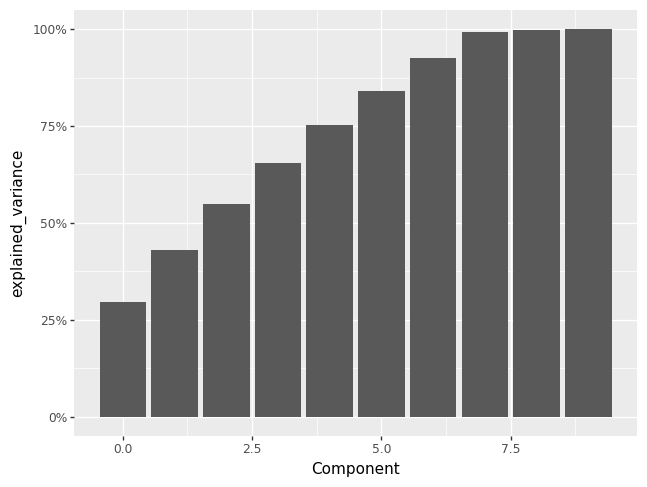

In [56]:
graph_data = pd.DataFrame(pca_pipeline['pca'].explained_variance_ratio_.cumsum(), columns=['explained_variance']).reset_index()

graph = pn.ggplot(graph_data, pn.aes(x='index', y='explained_variance')) + pn.geom_col() + pn.xlab('Component') + pn.scale_y_continuous(labels=percent_format())
graph.draw()

Visualizamos cuanto de la varianza cada componente explica y vemos que los primeros son los más importantes y luego cada uno aporta menos información.

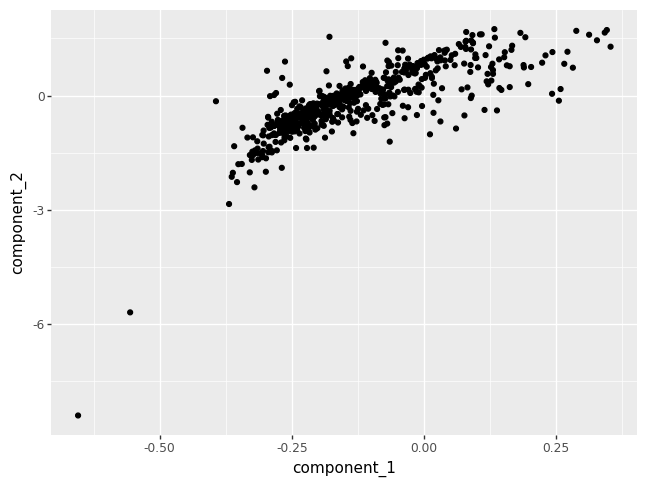

In [57]:
limit_x = transformed_data.component_1.quantile(0.95)
limit_y = transformed_data.component_2.quantile(0.95)

condition = (transformed_data.component_1 < limit_x) & (transformed_data.component_2 < limit_y)

graph = (
    pn.ggplot(transformed_data[condition], pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph.draw()

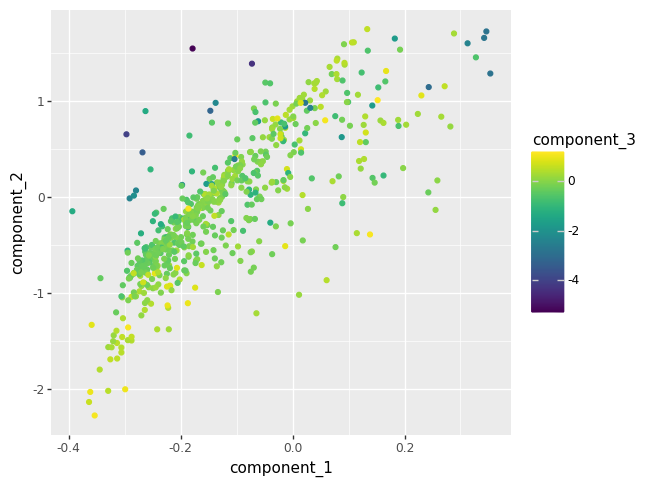

In [58]:
limit_x = transformed_data.component_1.quantile(0.95)
limit_y = transformed_data.component_2.quantile(0.95)
limit_z = transformed_data.component_3.quantile(0.95)

condition = (transformed_data.component_1 < limit_x) & (transformed_data.component_2 < limit_y) & (transformed_data.component_3 < limit_z)

graph = (
    pn.ggplot(transformed_data[condition], pn.aes(x='component_1', y='component_2', color='component_3'))
    + pn.geom_point()
)

graph.draw()

In [59]:
model = pca(n_components=3)
scaler = preprocessing.StandardScaler()
results = model.fit_transform(scaler.fit_transform(user_stats[variables]))

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [69]:
fig, ax = model.biplot3d(n_feat=6,  visible=False)
ax.set_xlim([-2, 6])
ax.set_ylim([-1, 4])
ax.set_zlim([-6, 5])
fig.set_visible(True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


In [ ]:
nums = [2, 3, 4, 7, 9]
[(num, variables[num]) for num in nums]

[(2, 'likes'), (3, 'tweets'), (4, 'media'), (7, 'retweet_id'), (9, 'nreplies')]

## T-SNE

In [ ]:
ncomponents = 2
tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('tsne', TSNE(ncomponents, random_state=0))
    ]
)

cols = ['component_' + str(i + 1) for i in range(ncomponents)]
transformed_data = pd.DataFrame(tsne_pipeline.fit_transform(user_stats[variables]), columns=cols)

/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [ ]:
transformed_data = pd.concat([transformed_data, user_stats[['name_user'] + variables]], axis=1)

In [73]:
transformed_data.head(2)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,-0.268872,-1.898280,1.337606,1.162749,0.760542,0.375701,1.172824,-0.342146,0.003711,-0.024972
1,-0.273508,-0.982969,0.425891,0.200878,-0.011969,0.003904,0.061316,0.139056,-0.014857,-0.003095


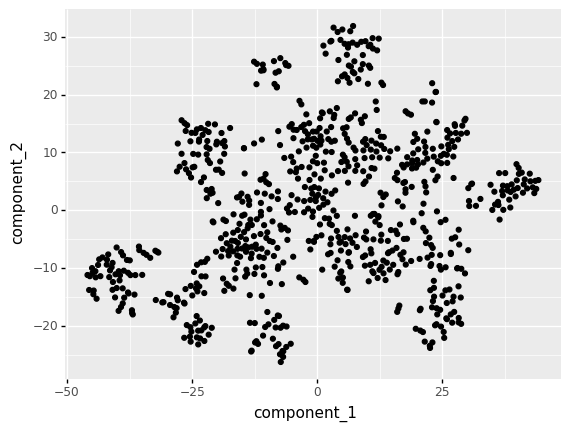

In [ ]:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph.draw();

Vemos cómo ahora tenemos una distribucion en 2 dimensiones bastante diferente a antes. En vez de estar todos los puntos concentrados en unas pocas partes del grafico, tenemos una distribucion mejor

Vamos a poner un color a los puntos que corresponde a las variables que vimos que eran importantes antes.

In [ ]:
vis_vars = ['following', 'followers', 'likes', 'avg_likes']

/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log


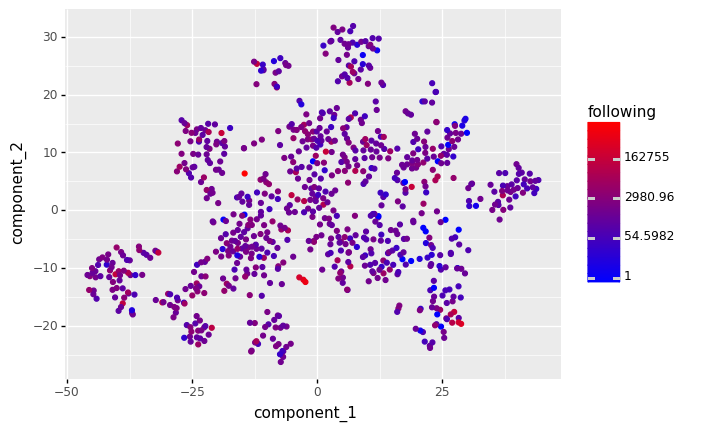

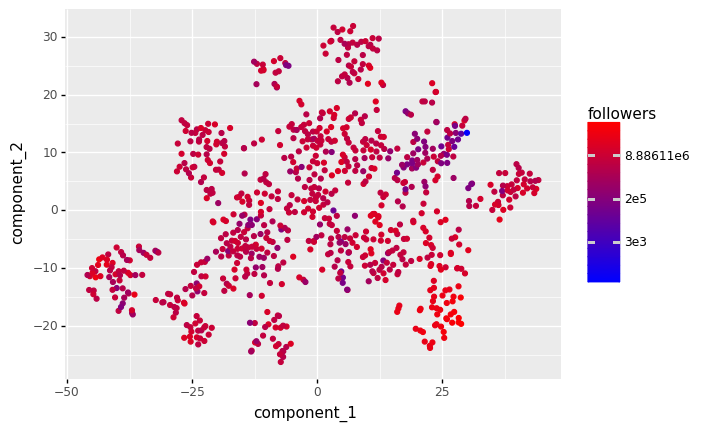

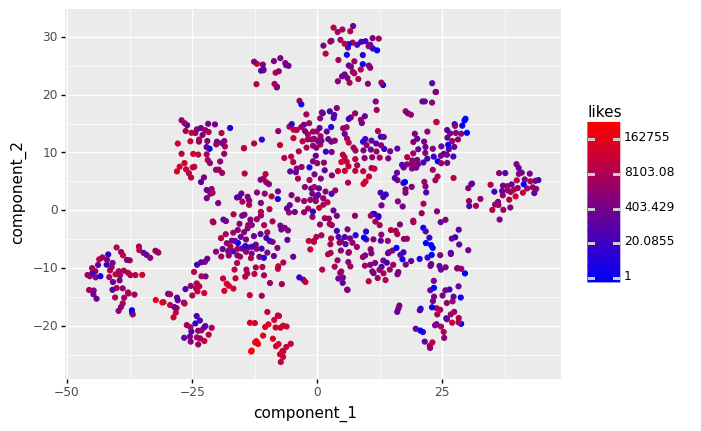

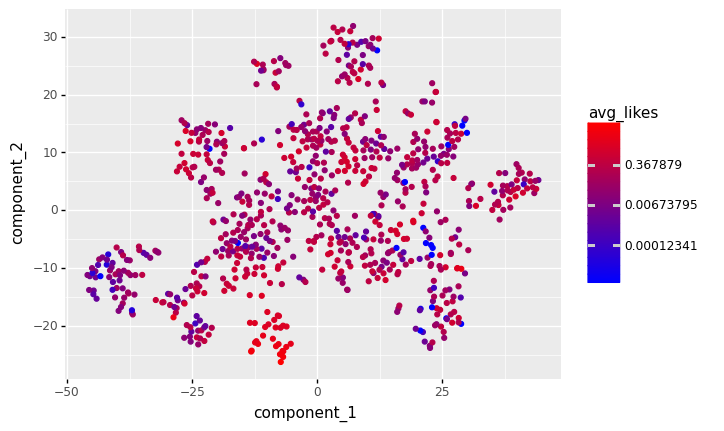

In [ ]:
for variable in vis_vars:
    graph = (
        pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2', color=variable))
        + pn.geom_point()
        + pn.scale_color_gradient(trans='log', low='blue', high='red')
    )

    graph.draw();

## Clustering

In [ ]:
X_variables = ['component_1', 'component_2']

kmeans_tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', DBSCAN(0.21, min_samples=12))
    ]
)

predictions = kmeans_tsne_pipeline.fit_predict(transformed_data[X_variables])
pd.DataFrame(predictions).value_counts()

 4    418
-1     63
 0     58
 6     52
 3     44
 5     42
 7     42
 1     36
 2     25
 8     16
dtype: int64

In [ ]:
transformed_data['predictions_clusters'] = predictions.astype(str)

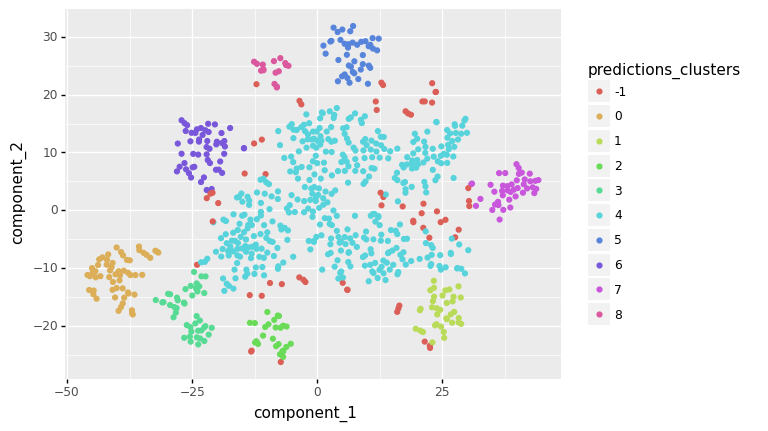

In [ ]:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2', color='predictions_clusters'))
    + pn.geom_point()
)

graph.draw();

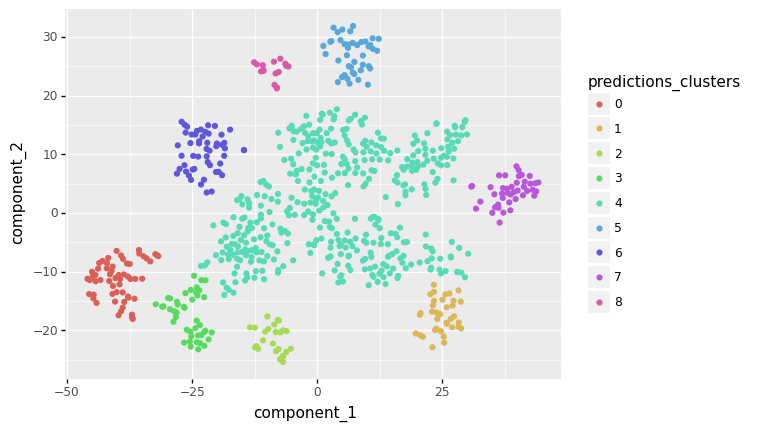

In [ ]:
graph = (
    pn.ggplot(transformed_data[transformed_data.predictions_clusters != '-1'], pn.aes(x='component_1', y='component_2', color='predictions_clusters'))
    + pn.geom_point()
)

graph.draw();

Dibujando los resultados y vemos que el algoritmo ha sido capaz de identificar unos clusters bastante claros. Parece ser que existe una gran masa de usuaros tipicos en el centro (el cluster 4) y luego tenemos grupos de usuarios en los diferentes lados. Los puntos en rojo (-1) son los que no acaban de pertenecer a ningún grupo especifico.

Y qué son estos clusters? Vamos a analizar los clusters en base de las variables originales:

In [ ]:
cols = [col for col in transformed_data if col not in X_variables + ['predictions_clusters']]

In [ ]:
transformed_data.groupby('predictions_clusters')[cols].mean()

,following,followers,likes,tweets,media,id,conversation_id,retweet_id,nlikes,nreplies,nretweets,number_hashtags,num_replies_to,num_photos,num_urls,avg_likes,avg_media,followers_per_tweet,num_days_created,bio_length
predictions_clusters,,,,,,,,,,,,,,,,,,,,
-1,108908.142857,9.951656e+06,16912.158730,25930.904762,6025.793651,30.476190,26.555556,3.190476,47739.009036,3261.105002,10730.651613,0.219170,0.162415,0.108798,0.014223,0.705390,0.294508,1873.618377,4264.492063,96.031746
0,7181.379310,8.502608e+06,5875.120690,219199.362069,68559.448276,404.758621,384.844828,28.603448,405.101863,23.456223,63.547951,0.037599,0.037293,0.013458,0.006593,0.040664,0.321893,44.053940,5022.120690,87.327586
1,30805.666667,5.733389e+07,3344.750000,23187.972222,4750.138889,19.500000,15.972222,1.916667,24507.613778,719.627700,2668.886807,0.116969,0.170986,0.079059,0.002022,0.158966,0.215602,5718.351727,4648.805556,52.694444
2,1599.480000,6.466238e+06,62793.800000,21444.600000,2459.120000,19.320000,16.920000,5.440000,2488.448067,59.515245,488.804126,0.106525,0.347957,0.023063,0.002667,3.459508,0.129337,521.130096,4510.760000,81.400000
3,5297.272727,6.311342e+06,14965.113636,61503.659091,6298.386364,112.613636,104.500000,56.886364,748.142289,38.443827,394.543425,0.101523,0.128976,0.029062,0.001151,0.311954,0.103420,214.035846,4509.545455,85.477273
4,2946.031100,5.751678e+06,4001.055024,18326.055024,2615.272727,13.705742,12.760766,2.851675,4322.053329,149.150199,685.847672,0.060752,0.028804,0.034356,0.001443,0.240298,0.194251,1334.323056,4317.495215,78.031100
5,1602.357143,5.699373e+06,3096.857143,16471.309524,2500.595238,8.404762,7.833333,1.761905,1240.278727,64.925482,210.690095,1.561980,0.042456,0.168788,0.003434,0.212075,0.161936,789.012786,4466.880952,87.738095
6,4962.115385,5.796069e+06,10160.865385,29738.788462,2201.500000,36.423077,21.211538,3.711538,2076.487529,71.979587,220.998710,0.026484,1.240510,0.021754,0.000852,0.330579,0.089988,372.164904,4503.750000,75.269231
7,1248.142857,7.451364e+06,3935.309524,13151.047619,2853.904762,7.666667,7.357143,0.833333,3388.077088,105.207429,389.099142,0.127513,0.022583,1.181896,0.006926,0.292872,0.258361,972.470052,4391.309524,72.214286


In [ ]:
transformed_data.groupby('predictions_clusters')[vis_vars].mean()

,following,followers,likes,avg_likes
predictions_clusters,,,,
-1,108908.142857,9.951656e+06,16912.158730,0.705390
0,7181.379310,8.502608e+06,5875.120690,0.040664
1,30805.666667,5.733389e+07,3344.750000,0.158966
2,1599.480000,6.466238e+06,62793.800000,3.459508
3,5297.272727,6.311342e+06,14965.113636,0.311954
4,2946.031100,5.751678e+06,4001.055024,0.240298
5,1602.357143,5.699373e+06,3096.857143,0.212075
6,4962.115385,5.796069e+06,10160.865385,0.330579
7,1248.142857,7.451364e+06,3935.309524,0.292872


In [ ]:
transformed_data.groupby('predictions_clusters')[vis_vars].mean().rank(ascending=False)

,likes,tweets,media,retweet_id,nreplies
predictions_clusters,,,,,
-1,2.0,4.0,3.0,5.0,1.0
0,6.0,1.0,1.0,2.0,10.0
1,9.0,5.0,4.0,7.0,2.0
2,1.0,6.0,9.0,3.0,8.0
3,3.0,2.0,2.0,1.0,9.0
4,7.0,8.0,7.0,6.0,3.0
5,10.0,9.0,8.0,8.0,7.0
6,4.0,3.0,10.0,4.0,6.0
7,8.0,10.0,6.0,10.0,4.0


In [ ]:
prct_changes = ((transformed_data.groupby('predictions_clusters')[vis_vars].mean() - transformed_data[vis_vars].mean()) / transformed_data[vis_vars].mean()).reset_index()
graph_data = pd.melt(prct_changes, 'predictions_clusters')

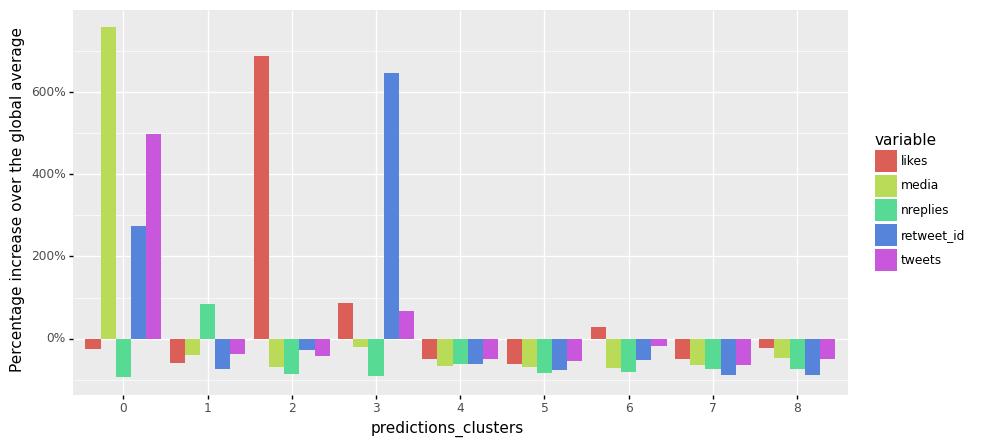

In [ ]:
graph = (
    pn.ggplot(graph_data[graph_data.predictions_clusters != '-1'], pn.aes(x='predictions_clusters', y='value', fill='variable'))
    + pn.geom_col(position='dodge')
    + pn.theme(figure_size=(10, 5))
    + pn.scale_y_continuous(labels=percent_format())
    + pn.scale_x_discrete(labels=[str(i) for i in range(graph_data[graph_data.predictions_clusters != '-1'].predictions_clusters.nunique())])
    + pn.ylab('Percentage increase over the global average')
)

graph.draw();

In [ ]:
transformed_data[transformed_data.predictions_clusters == '0'].sort_values('tweets', ascending=False)['name_user'].head()

105                  Slate
8       The New York Times
12                Mashable
15                Fox News
17     The Washington Post
Name: name_user, dtype: object

In [ ]:
transformed_data[transformed_data.predictions_clusters == '2'].sort_values('tweets', ascending=False)['name_user'].head()

193          Ricky Gervais
615    Alejandro Vigilante
49           Felicia Day🇺🇸
90              KevinSmith
30            Paulo Coelho
Name: name_user, dtype: object

In [ ]:
transformed_data[transformed_data.predictions_clusters == '3'].sort_values('tweets', ascending=False)['name_user'].head()

172                 Perez Hilton
155                  Neil Gaiman
343                 Chad Johnson
705    #مصطفى_الآغا Mustafa Agha
129                   Soulja Boy
Name: name_user, dtype: object

Apreciamos por ejemplo que el 0 son mayormente prensa, el 2 parecen personas famosas del mundo de cultura, mientras y el 10 parecen personas famosas pero por otros temas.